In [63]:
# Imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypdf import PdfWriter

from geoscripts import gchemplots as gp
from geoscripts import gchemcalc as gc

from matplotlib import rc
rc("pdf", fonttype=42)

pd.options.mode.copy_on_write = True

In [64]:
# Set up directory
savedir = 'draft_figs/'
os.makedirs(savedir,exist_ok=True)

In [65]:
# New Data
data = pd.read_csv('processed/data.csv',index_col=0)

# Filter for J
filter_period = (data['Period']=='Jurassic')|(data['Period']=='Jurassic?')

# Filter for LOI
filter_LOI = data['LOI %']<=7

data_filt = data[filter_period&filter_LOI]
print(data_filt.index)

Index(['G22019', 'G22020', 'G22032A', 'G22033', 'G22034', 'G22035', 'G22036A',
       'G22037', 'G22038', 'G22039', 'G22041A', 'G22044', 'G22045', 'G22049',
       'G22051', 'G22053', 'G22063', 'G22065', 'G22066', 'G22067', 'G22068A',
       'G22068B', 'G22068C', 'G22069', 'G22076', 'G22081', 'G22091', 'G22094',
       'G22096', 'G22109', 'G22110', 'G22111', 'G22114', 'G22118', 'G22119',
       'G22125', 'G22126', 'G22129', 'G22130', 'G22131', 'G22141', 'C17069B',
       '100311-3A'],
      dtype='object')


In [66]:
# Groups
khaishi_core_smps = ['G22034','G22035','G22036A','G22037','G22038','G22039']
data_filt.loc[khaishi_core_smps,'S_Domain'] = 'Khaishi Core'

limb_condition = (~data_filt.index.isin(khaishi_core_smps)) & (data_filt['S_Domain'] == 'Khaishi')
data_filt.loc[limb_condition,'S_Domain'] = 'Khaishi Limbs'

group_dict = {'Khaishi Core':'Khaishi Core','Khaishi Limbs':'Khaishi Limbs','Idliani':'Idliani','Jvari':'Jvari','Lentekhi':'Lentekhi','Mazashi':'Mazashi','Panaga':'Lentekhi',
              'Tsageri-Khvamli':'Khvamli','Dzirula':np.nan,'Pasanauri':np.nan,'Dizi':np.nan,'Cretaceous Intrusive':np.nan}

chem_group = data_filt['S_Domain'].map(group_dict)

groups = data_filt.groupby(chem_group,sort=False)

color_dict = {'Khaishi Core':'#88CCEE','Khaishi Limbs':'#44AA99','Idliani':'#117733','Jvari':'#999933','Lentekhi':'#AA4499','Mazashi':'#882255','Khvamli':'#CC6677',
              np.nan:'#DDDDDD'}

axes_dict = {'Khaishi Core':(0,0),'Khaishi Limbs':(0,0),'Idliani':(1,0),'Jvari':(2,0),'Lentekhi':(0,1),'Mazashi':(1,1),'Khvamli':(2,1)}

In [67]:
# Save Data
data_filt['Color'] = chem_group.map(color_dict)
plot_data = data_filt[data_filt['Color']!='#DDDDDD']

plot_data.to_csv(savedir+'data.csv')

In [68]:
# Organize data into table
data_filt['Geochemical Domain'] = chem_group
columns = ['Latitude','Longitude','Rock_Type','Geochemical Domain']
table = data_filt[columns].rename(columns={'Latitude':'Latitude (°N)','Longitude':'Longitude (°E)','Rock_Type':'Lithology'})
table.dropna(subset=['Geochemical Domain'],inplace=True)
table.index.name = 'Sample'

table.replace({'Breccia':'Volcaniclastic','Intermed. Volcanic':'Andesite','Sandstone':'Volcaniclastic'},inplace=True)
intermed_condition = (data_filt['SiO2']>57) & (table['Lithology']=='Mafic Intrusive')

table.loc[intermed_condition,'Lithology'] = 'Intermediate Intrusive'

table.to_csv('Table1.csv')


In [69]:
# Create version for EarthChem table
os.makedirs('earth_chem',exist_ok=True)

# Sample table
sample_cols = ['IGSN','LATITUDE','LONGITUDE','ELEVATION','LOCATION KEYWORDS','LITHOLOGY','age']
sample_table = pd.DataFrame(columns=sample_cols,index=table.index)
sample_table.index.name = 'SAMPLE NAME'

sample_table[['LATITUDE','LONGITUDE','LITHOLOGY']] = table[['Latitude (°N)','Longitude (°E)','Lithology']]
sample_table['ELEVATION'] = data_filt['Elevation'].round(0)
sample_table['LOCATION KEYWORDS'] = 'Caucasus'
sample_table['age'] = 'Jurassic'

# Manually fill missing elevations
sample_table.loc['G22119','ELEVATION'] = 264
sample_table.loc['100311-3A','ELEVATION'] = 742

sample_table.to_csv('earth_chem/sample.csv')

# Data table

data_cols_start = ['IGSN','ANALYZED MATERIAL','species','size fraction','sample preparation','chemical treatment',
            'number of replicates']
data_cols_xrf = ['SiO2','TiO2','Al2O3','FeOT','MnO','MgO','CaO','Na2O','K2O','P2O5','LOI','Ni','Cr','V','Ga','Cu',
                      'Zn']
data_cols_icpms = ['La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Ba','Th','Nb','Y',
                      'Hf','Ta','U','Pb','Rb','Cs','Sr','Sc','Zr']
cols_new = data_cols_xrf+data_cols_icpms

data_table = pd.DataFrame(columns=data_cols_start+cols_new,index=table.index)
data_table.index.name = 'SAMPLE NAME'

cols_old = ['SiO2_unnorm', 'TiO2_unnorm', 'Al2O3_unnorm', 'FeO*_unnorm',
       'MnO_unnorm', 'MgO_unnorm', 'CaO_unnorm', 'Na2O_unnorm', 'K2O_unnorm',
       'P2O5_unnorm','LOI %','Ni','Cr','V','Ga','Cu','Zn','La','Ce','Pr','Nd','Sm',
       'Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Ba','Th','Nb','Y',
        'Hf','Ta','U','Pb','Rb','Cs','Sr','Sc','Zr']

data_table[cols_new] = data_filt[cols_old]
data_table['ANALYZED MATERIAL'] = 'whole rock'

data_table.to_csv('earth_chem/data.csv')

# Method Table
method_cols = [					
'METHOD CODE','PARAMETER','TECHNIQUE','INSTRUMENT','LABORATORY'
]
method_table = pd.DataFrame(index=cols_new,columns=method_cols)
method_table['PARAMETER'] = cols_new

xrf = method_table['PARAMETER'].isin(data_cols_xrf)
icpms = method_table['PARAMETER'].isin(data_cols_icpms)

method_table.loc[xrf,'METHOD CODE'] = 1
method_table.loc[icpms,'METHOD CODE'] = 2
method_table.loc[xrf,'TECHNIQUE'] = 'XRF'
method_table.loc[icpms,'TECHNIQUE'] = 'ICP:MS'
method_table.loc[xrf,'INSTRUMENT'] = 'ThermoARL Advant XP+'
method_table.loc[icpms,'INSTRUMENT'] = 'Agilent 7700'
method_table['LABORATORY'] = 'Washington State University'

method_table.to_csv('earth_chem/method.csv',index=None)

In [70]:
# Old Data
gale = pd.read_csv('processed/data_gale.csv')

cbab = pd.read_excel('published/Vasey_CaucArc_TableS4.xlsx',header=1)
spreading_cond = cbab['Region'].isin(['Okinawa Trough','Bransfield Strait','Tyrrhenian Sea'])
cbab_spread = cbab[spreading_cond]

avgs_raw = pd.read_csv('published/Vasey21_avgs.csv',header=0,index_col=0)
avgs = avgs_raw.loc[['D-MORB','E-MORB','Oceanic Arc','OIB'],:]
avgs_colors = {'D-MORB':'#997700','E-MORB':'#EECC66','Oceanic Arc':'#6699CC','OIB':'#EE99AA'}

mc_cond = cbab['Source']=='McCann et al., 2010'
mc = cbab[mc_cond]

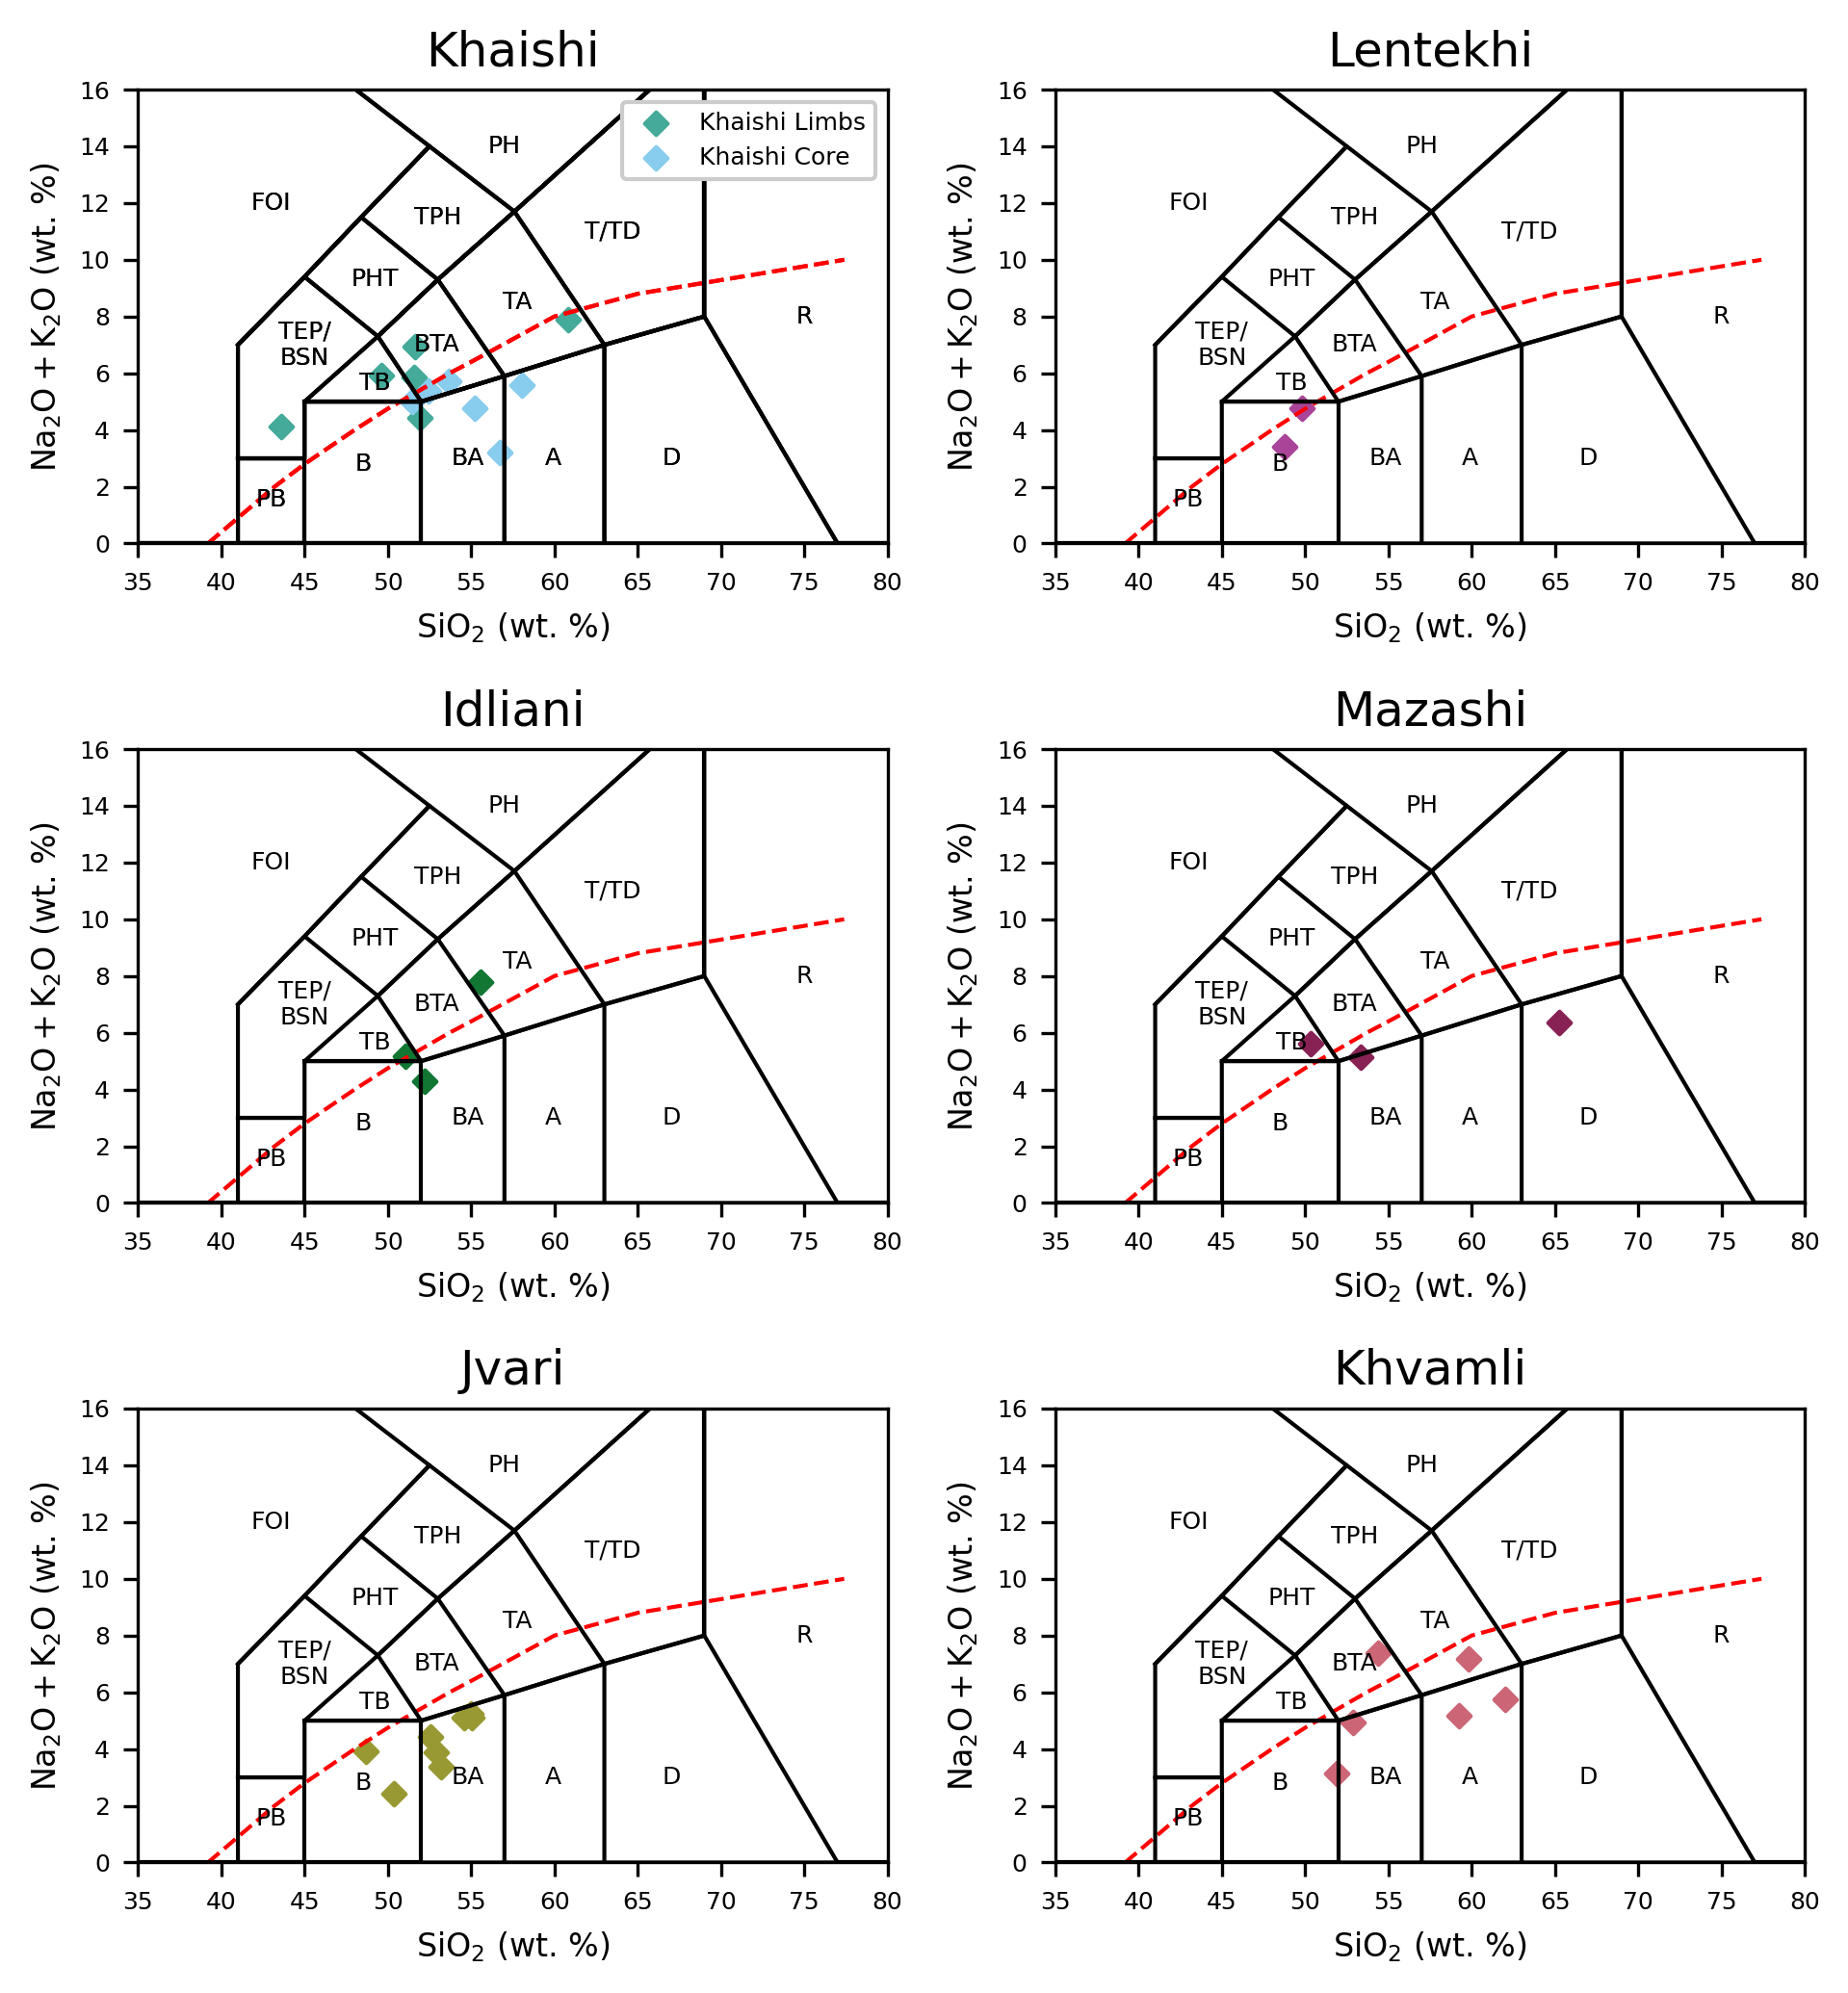

In [71]:
# TAS
fig,axs = plt.subplots(3,2,dpi=300,figsize=(6.5,7))

for k, group in groups:
    ax = axs[axes_dict[k]]
    color = color_dict[k]
    SiO2,Na2O,K2O = group[['SiO2','Na2O','K2O']].T.values
    gp.TASsm(SiO2,Na2O,K2O,label=k,ax=ax,color=color,first=[])
    ax.set_title(k)
axs[0,0].set_title('Khaishi')
axs[0,0].legend(fontsize=6,loc='upper right',frameon=True,framealpha=1,facecolor='white')

plt.tight_layout()

fig.savefig(savedir+'F06_TAS.pdf')

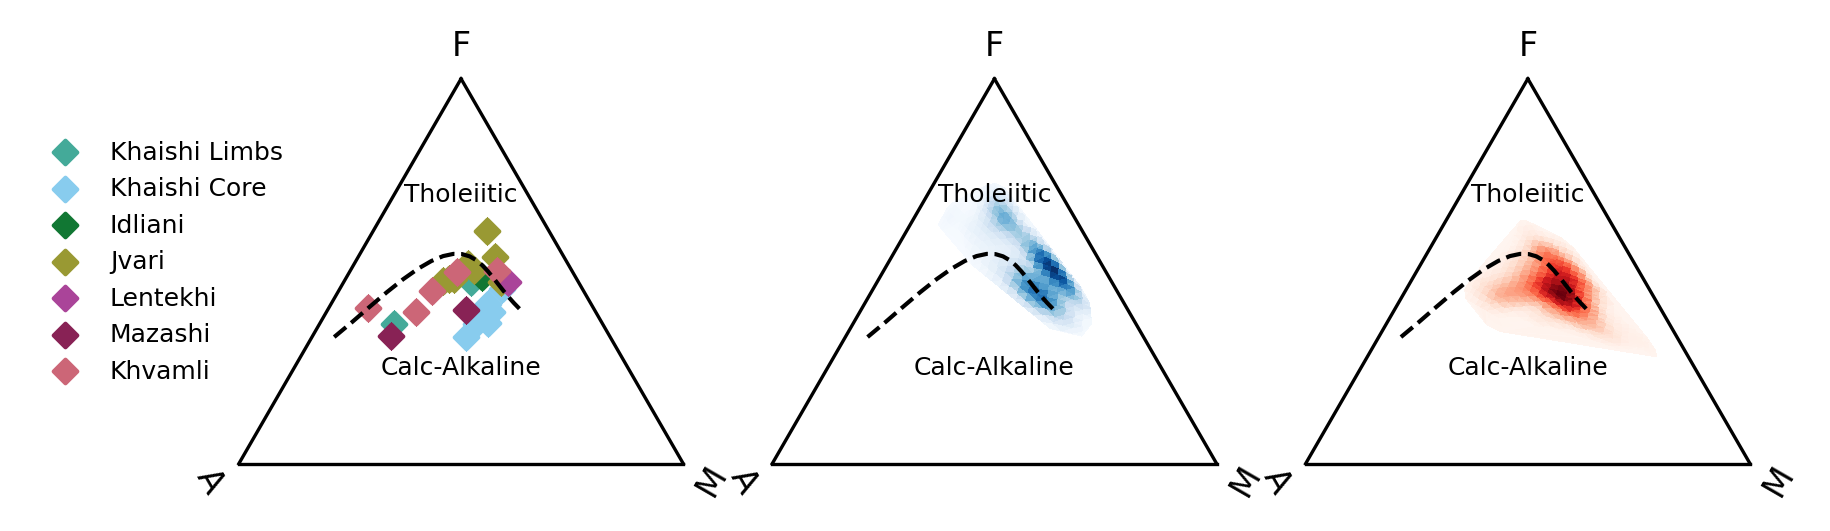

In [72]:
# AFM
fig,axs = plt.subplots(1,3,figsize=(6.5,3),dpi=300,subplot_kw={'projection':'ternary'})

first = []
for k,group in groups:
    group_sub = gc.classifyAlkaline(group)
    group_filt = group[group_sub]

    gp.afm(Na2O=group_filt['Na2O'],K2O=group_filt['K2O'],FeOt=group_filt['FeO*'],MgO=group_filt['MgO'],ax=axs[0],scatter=True,
       density=False,scatter_kwargs={'color':color_dict[k],'label':k},first=first)

gale_sub = gc.classifyAlkaline(gale)
gale_filt = gale[gale_sub]

gp.afm(Na2O=gale_filt['Na2O'],K2O=gale_filt['K2O'],FeOt=gale_filt['FeOt'],MgO=gale_filt['MgO'],ax=axs[1],scatter=False,
       density=True,first=[],density_kwargs={'cmap':'Blues'})

cbab_sub = gc.classifyAlkaline(cbab_spread)
cbab_filt = cbab_spread[cbab_sub]

gp.afm(Na2O=cbab_filt['Na2O'],K2O=cbab_filt['K2O'],FeOt=cbab_filt['FeOt'],MgO=cbab_filt['MgO'],ax=axs[2],scatter=False,
       density=True,first=[],density_kwargs={'cmap':'Reds'})

axs[0].legend(fontsize=6,loc='best',bbox_to_anchor=(0.15,0.9))

fig.savefig(savedir+'F07_AFM.pdf')

4
4
4
4
4
4
4
4
4
4
4


/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWar

4
4
4
1
1
1


/home/dyvasey/git/geoscripts/geoscripts/gchemplots.py:565: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.update(pti_ppm)
/home/dyvasey/git/geoscripts/geoscripts/gchemplots.py:565: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.update(pti_ppm)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/git/geoscripts/geoscripts/gchemplots.py:565: FutureWarning: In a future v

1
1
1
1
1
1
1
1
1


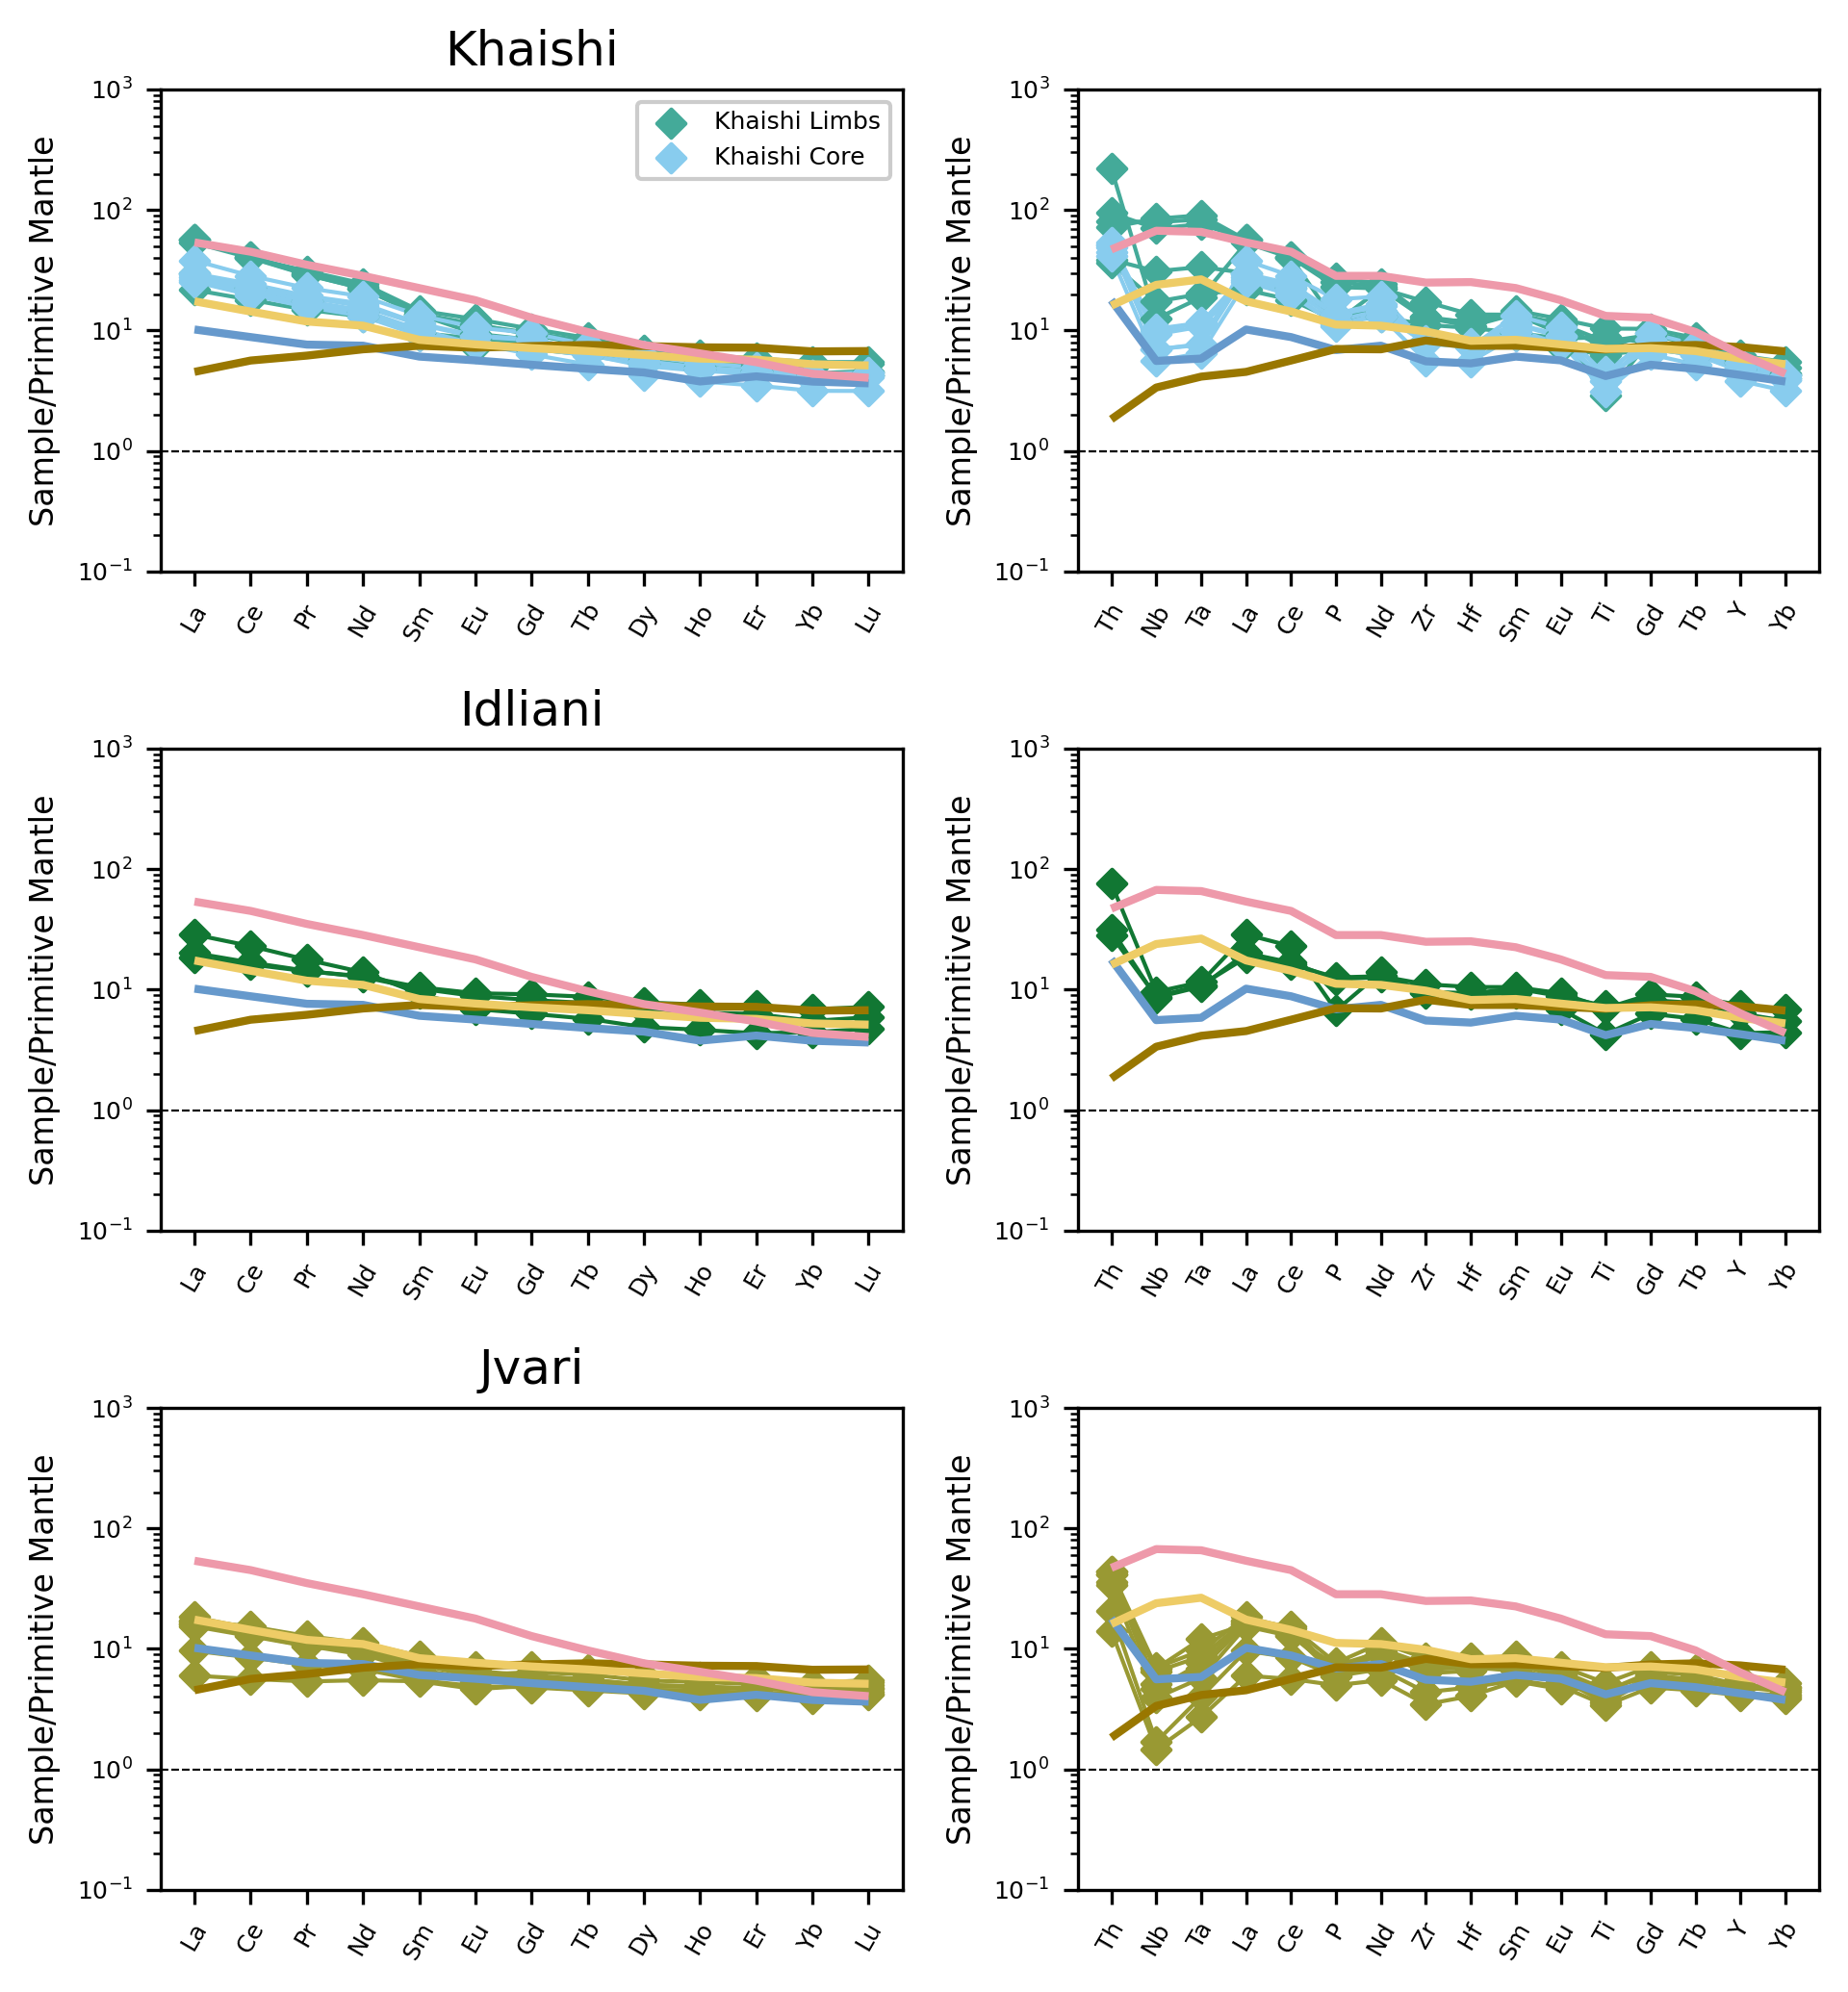

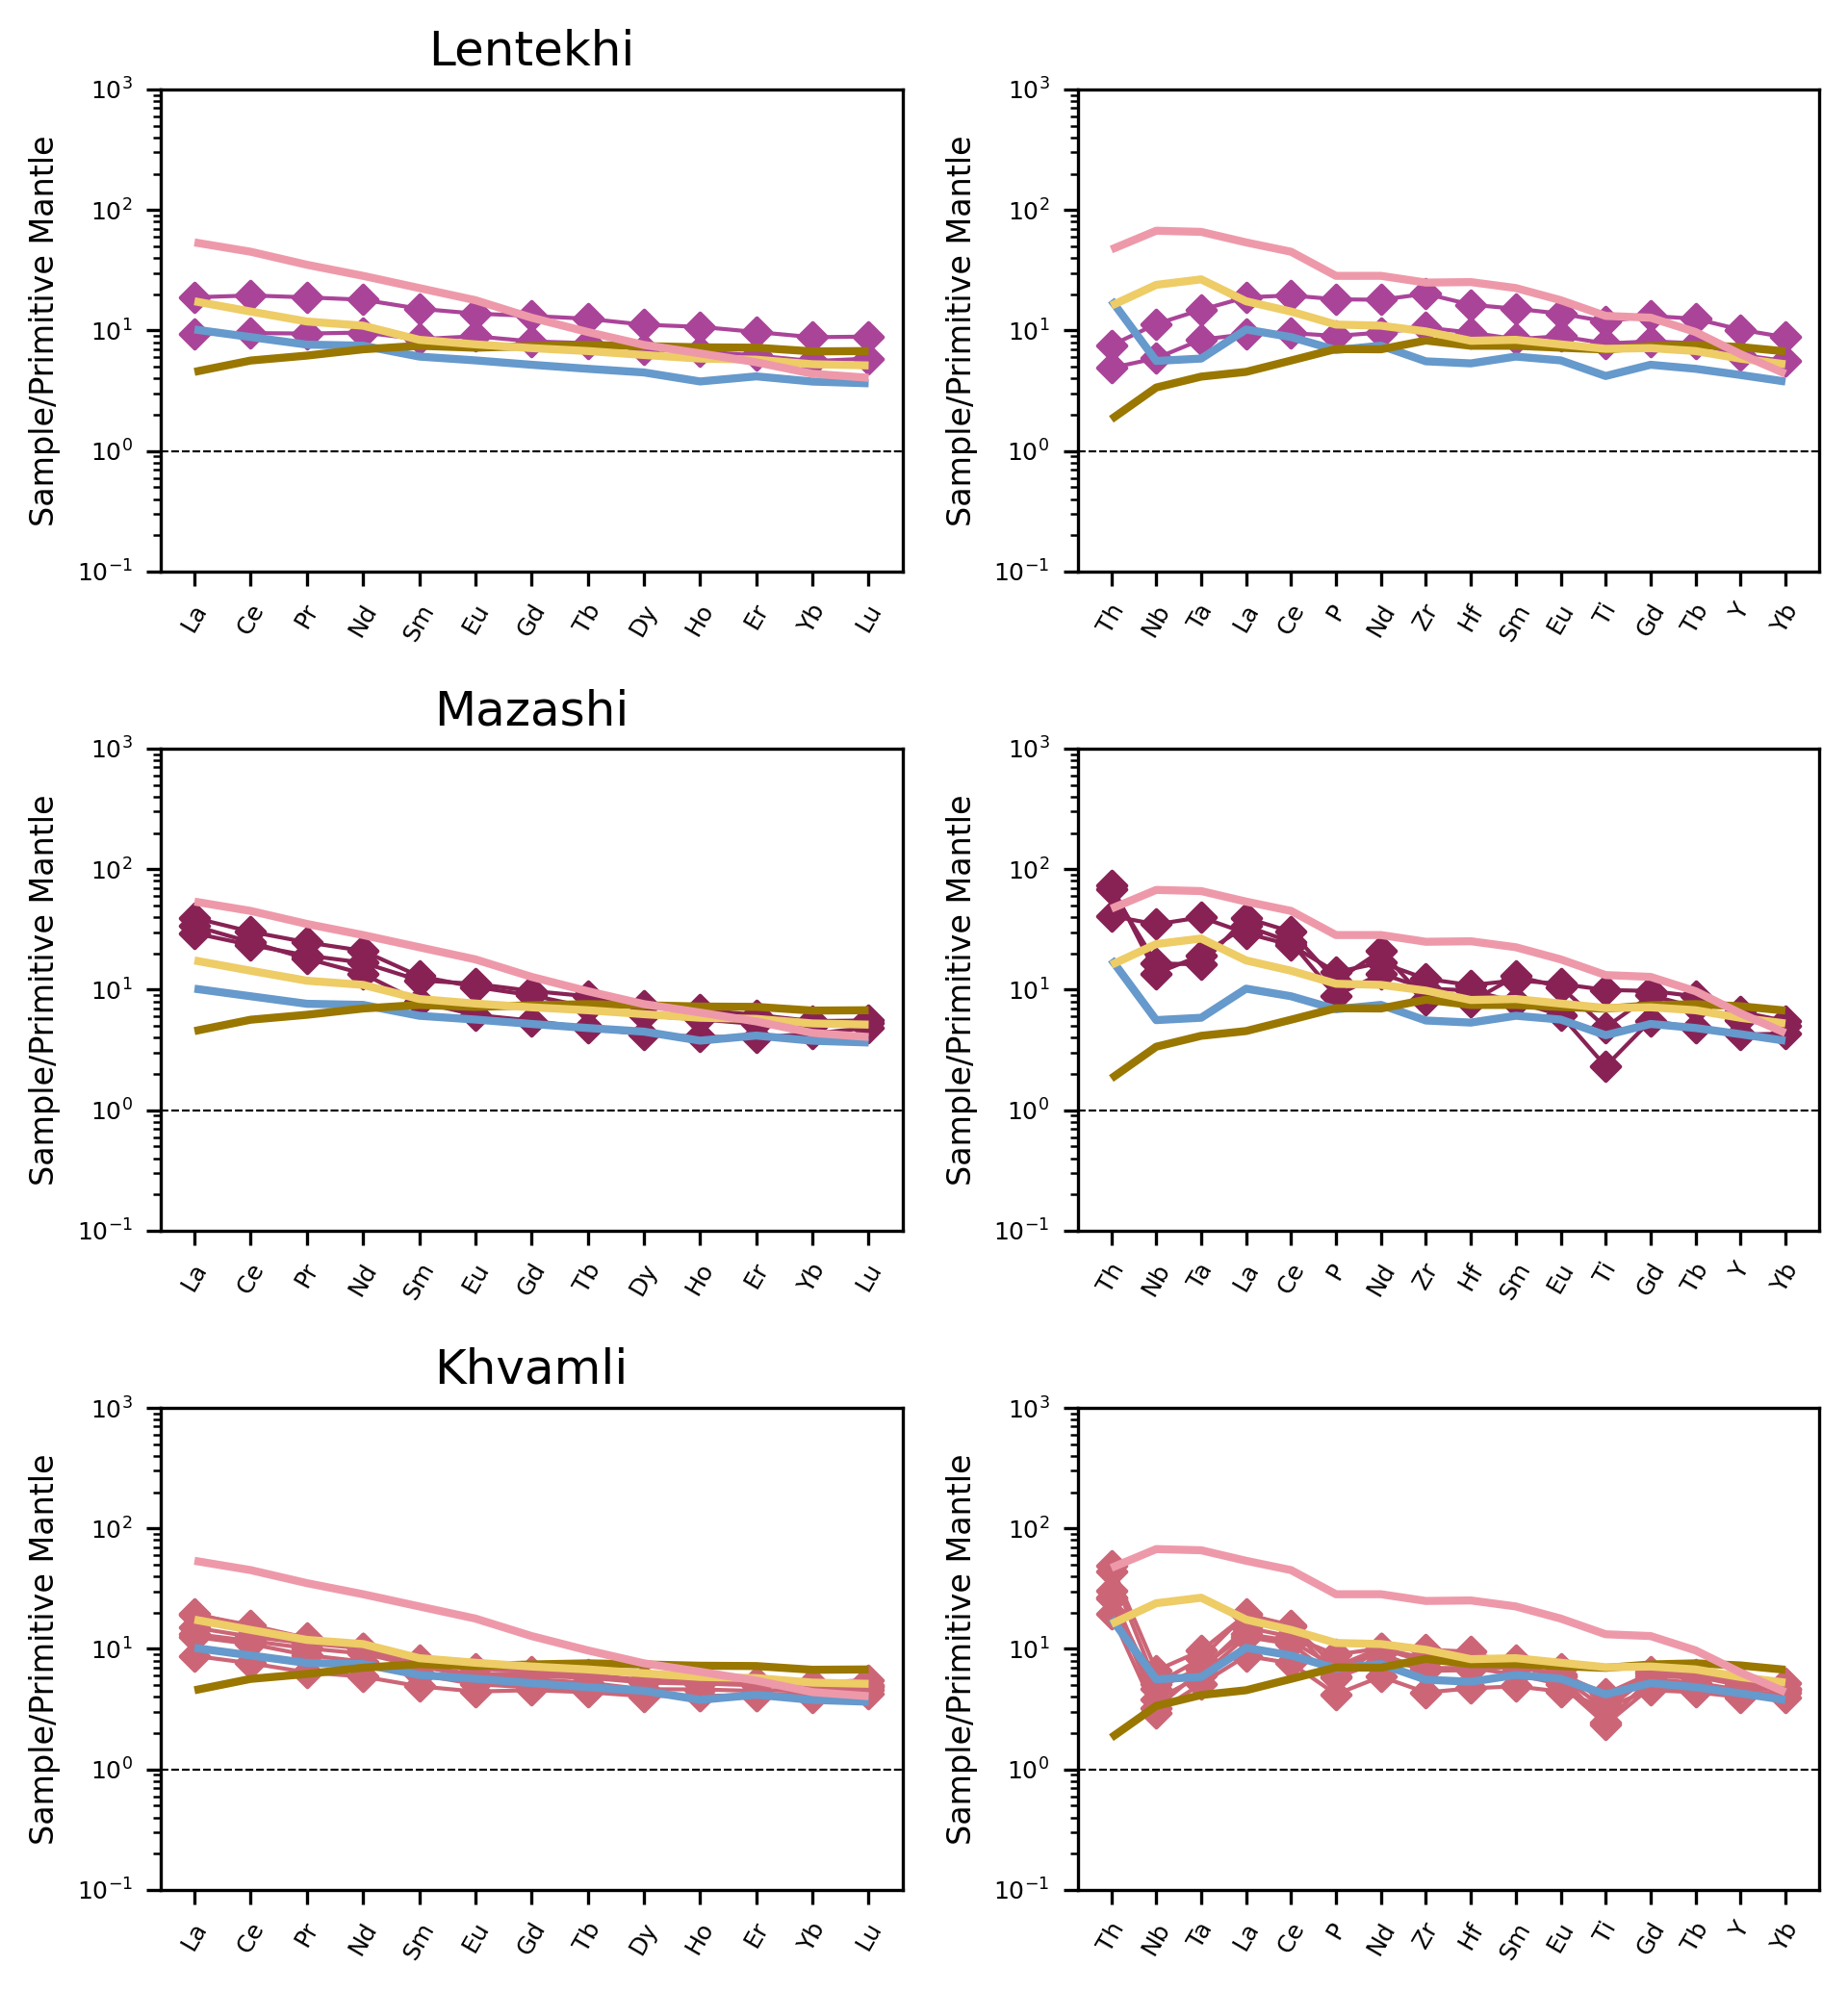

In [73]:
# Spiders

fig0,axs0 = plt.subplots(3,2,figsize=(6.5,7),dpi=300)
fig1,axs1 = plt.subplots(3,2,figsize=(6.5,7),dpi=300)

axs_all = [axs0,axs1]

for k, group in groups:
    fignum = axes_dict[k][1]
    axs = axs_all[fignum]

    ax0 = axs[(axes_dict[k][0],0)]
    ax1 = axs[(axes_dict[k][0],1)]

    ax0.set_title(k)

    gp.REE(group,ax=ax0,c=color_dict[k],label=k)
    gp.immobile(group,ax=ax1,c=color_dict[k],label=k)

axs0[0,0].set_title('Khaishi')
axs0[0,0].legend(fontsize=6,loc='upper right',frameon=True,framealpha=1,facecolor='white')

# Old averages list for having different curves on each plot
#avgs_list = [['Oceanic Arc','E-MORB','OIB'],['Oceanic Arc'],['Oceanic Arc'],['D-MORB','E-MORB'],['Oceanic Arc','E-MORB','OIB'],['Oceanic Arc']]

avgs_list = ['Oceanic Arc','D-MORB','E-MORB','OIB']

for k,ax in enumerate(axs0[:,0]):
    labels = avgs_list
    colors = [avgs_colors[label] for label in labels]
    gp.REE(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)
for k,ax in enumerate(axs0[:,1]):
    labels = avgs_list
    colors = [avgs_colors[label] for label in labels]
    gp.immobile(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)
for k,ax in enumerate(axs1[:,0]):
    labels = avgs_list
    colors = [avgs_colors[label] for label in labels]
    gp.REE(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)
for k,ax in enumerate(axs1[:,1]):
    labels = avgs_list
    colors = [avgs_colors[label] for label in labels]
    gp.immobile(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)

fig0.set_layout_engine('tight')
fig1.set_layout_engine('tight')

fig0.savefig(savedir+'F08_westspiders.pdf')
fig1.savefig(savedir+'F09_eastspiders.pdf')

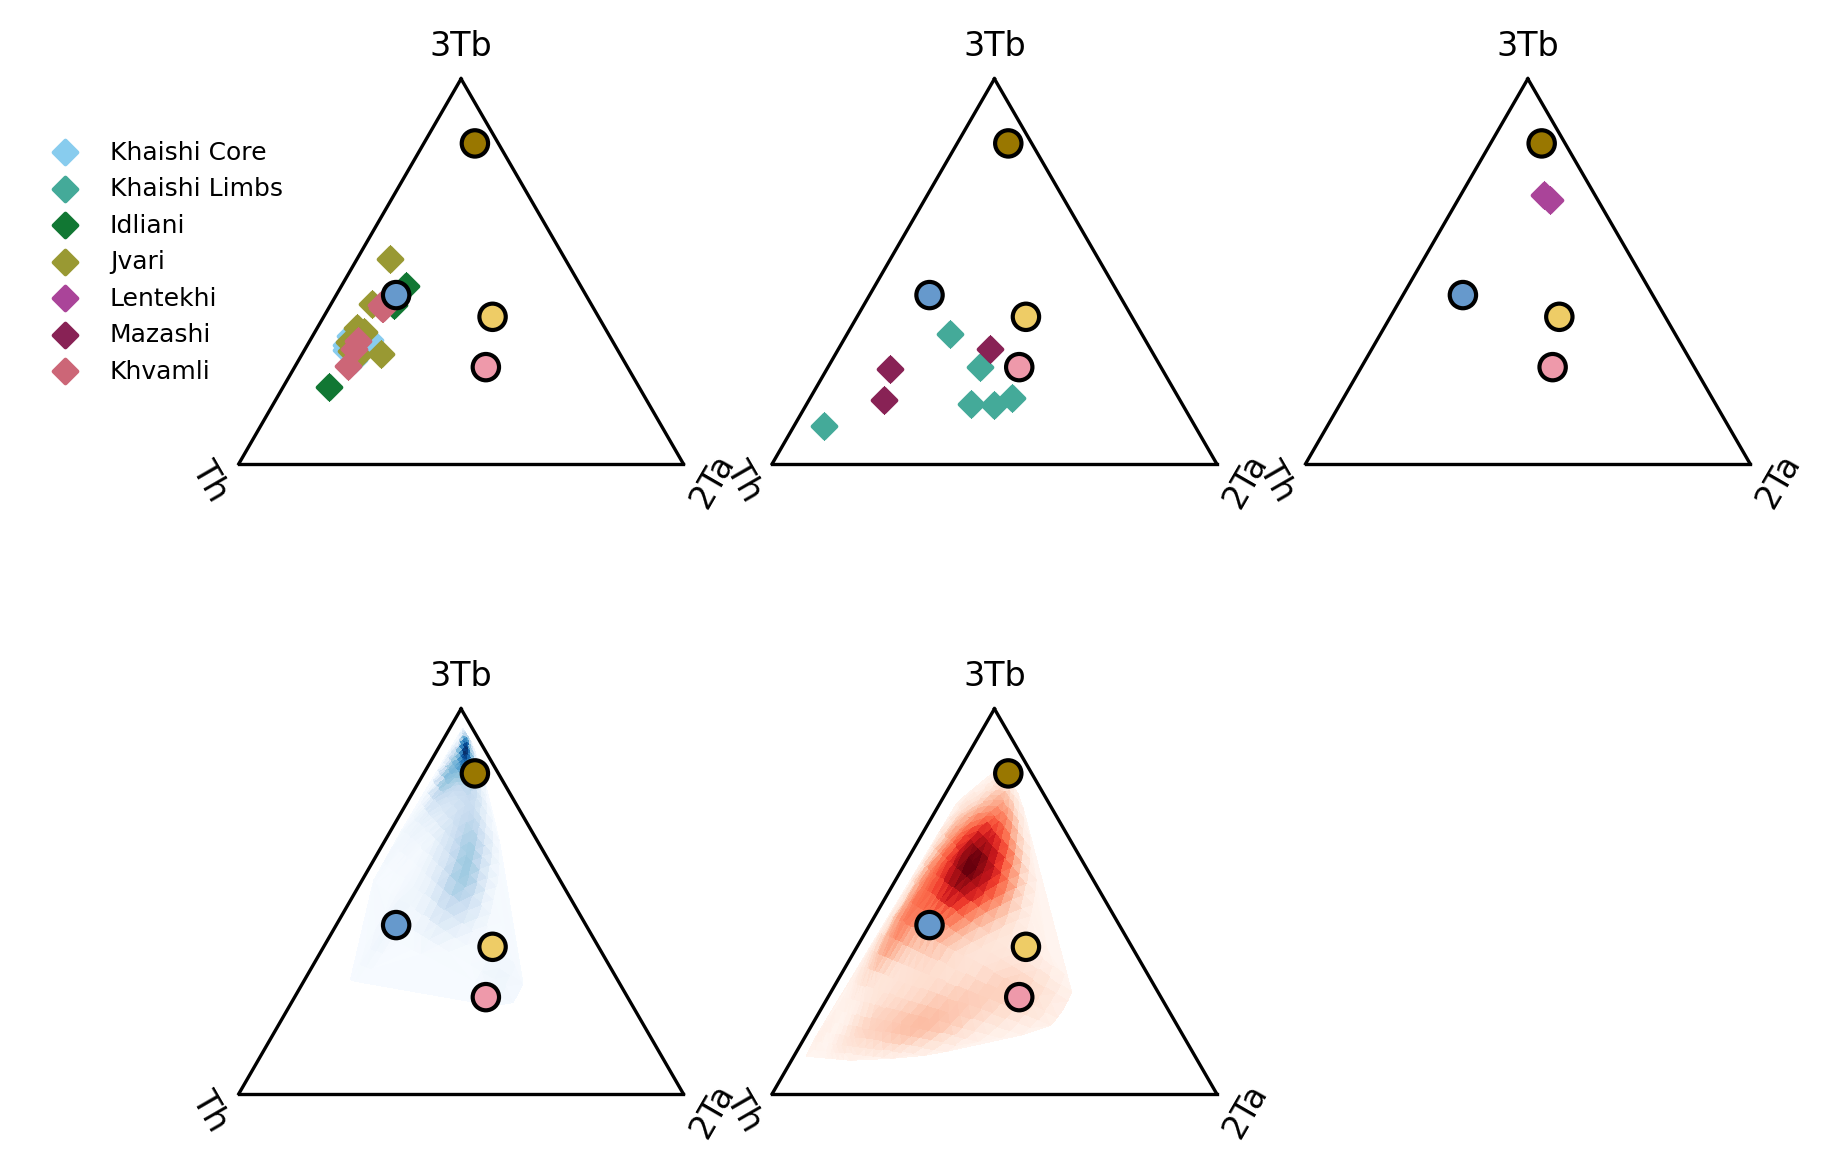

In [74]:
# Cabanis
fig,axs = plt.subplots(2,3,figsize=(6.5,5),dpi=300,subplot_kw={'projection':'ternary'})
axs[1,2].remove()

first = []
for k,group in groups:
    if k in ['Jvari','Idliani','Khvamli','Khaishi Core']:
        ax = axs[0,0]
    elif k in ['Khaishi Limbs','Mazashi']:
        ax = axs[0,1]
    elif k=='Lentekhi':
        ax = axs[0,2]
    Tb,Th,Ta = group[['Tb','Th','Ta']].T.values
    gp.cabanis(Tb,Th,Ta,ax=ax,label=k,c=color_dict[k])

gp.cabanisd(gale['Tb'],gale['Th'],gale['Ta'],ax=axs[1,0],cmap='Blues')
gp.cabanisd(cbab_spread['Tb'],cbab_spread['Th'],cbab_spread['Ta'],ax=axs[1,1],cmap='Reds')

for ax in axs.flatten():
    colors = [avgs_colors[label] for label in avgs.index]
    gp.cabanis(avgs['Tb'],avgs['Th'],avgs['Ta'],ax=ax,c=colors,marker='o',s=40,edgecolor='black')


h1, l1 = axs[0,0].get_legend_handles_labels()
h2, l2 = axs[0,1].get_legend_handles_labels()
h3, l3 = axs[0,2].get_legend_handles_labels()

legend_order = ['Khaishi Core','Khaishi Limbs','Idliani','Jvari','Lentekhi','Mazashi','Khvamli']
legend_dict = dict(zip(l1+l2+l3,h1+h2+h3))
handles_sorted = [legend_dict[x] for x in legend_order]

axs[0,0].legend(handles_sorted,legend_order,fontsize=6,loc='best',bbox_to_anchor=(0.15,0.9))

#fig.tight_layout()
fig.savefig(savedir+'F10_cabanis.pdf')

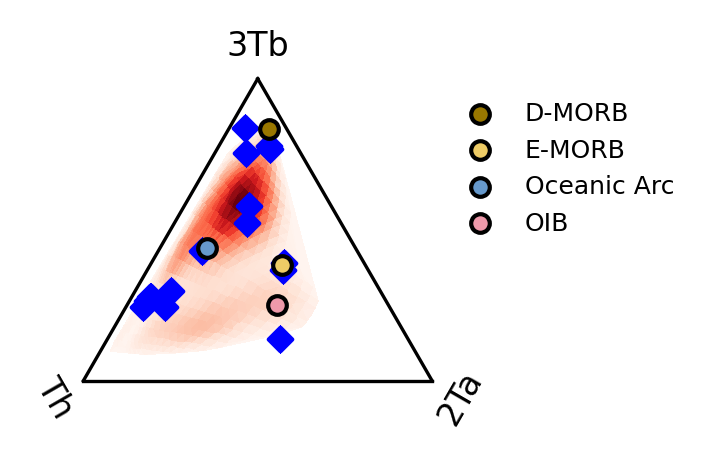

In [75]:
# Cabanis with McCann
fig,axs = plt.subplots(1,figsize=(1.5,1.5),dpi=300,subplot_kw={'projection':'ternary'})

first = []

gp.cabanisd(cbab_spread['Tb'],cbab_spread['Th'],cbab_spread['Ta'],ax=axs,cmap='Reds')
Tb,Th,Ta = mc[['Tb','Th','Ta']].T.values
gp.cabanis(Tb,Th,Ta,ax=axs,c='blue')

for k,row in avgs.iterrows():
    color = avgs_colors[k]
    label = k
    gp.cabanis(row['Tb'],row['Th'],row['Ta'],ax=axs,c=color,marker='o',s=20,edgecolor='black',label=label)

axs.legend(fontsize=6)

fig.savefig(savedir+'mccann_cabanis.pdf')

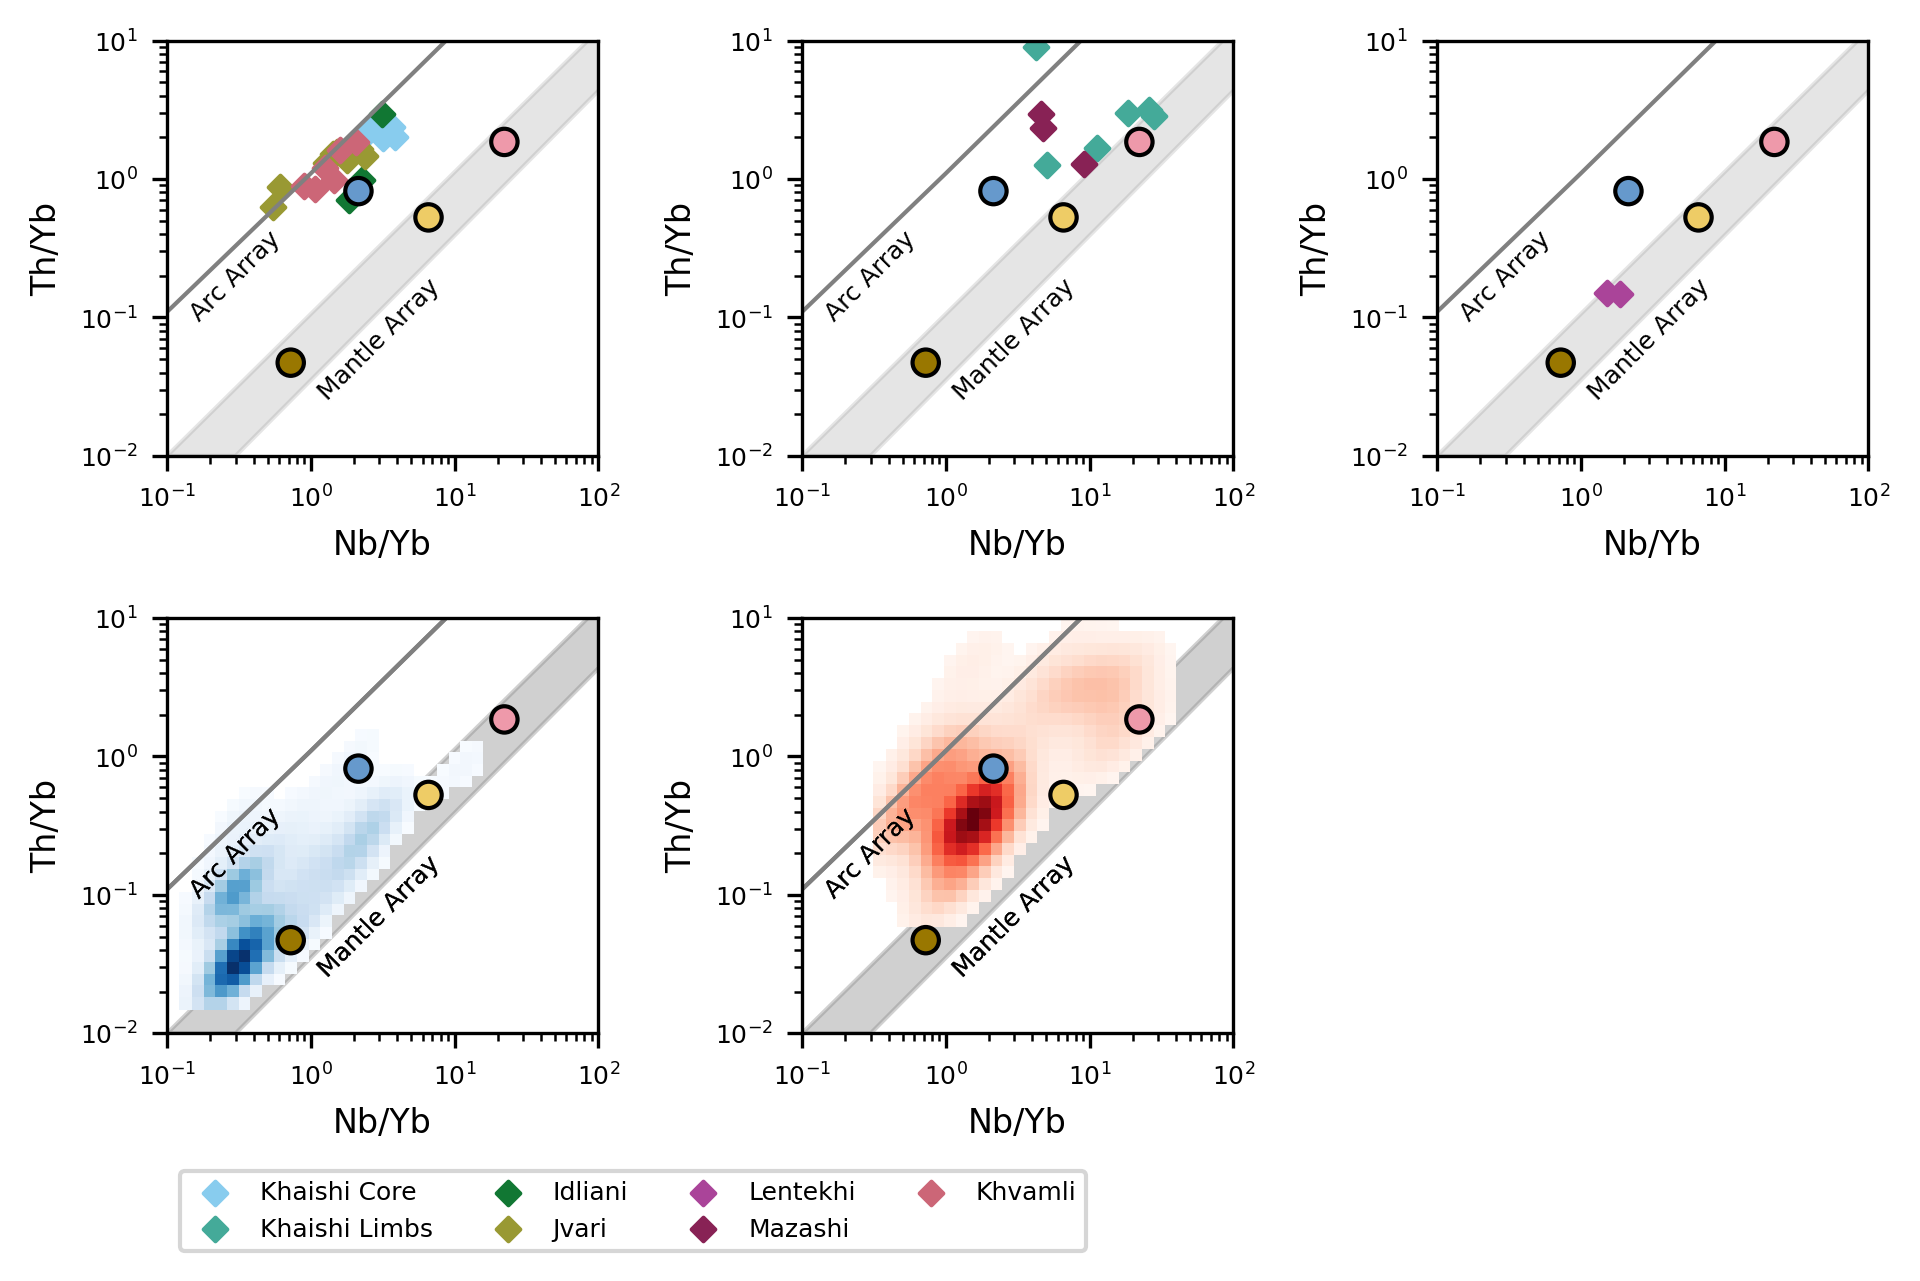

In [76]:
# Mantle Array
fig,axs = plt.subplots(2,3,figsize=(6.5,4),dpi=300)

axs[1,2].remove()

for k,group in groups:
    if k in ['Jvari','Idliani','Khvamli','Khaishi Core']:
        ax = axs[0,0]
    elif k in ['Khaishi Limbs','Mazashi']:
        ax = axs[0,1]
    elif k=='Lentekhi':
        ax = axs[0,2]
    Th,Nb,Yb = group[['Th','Nb','Yb']].T.values
    gp.mantle_array(Th,Nb,Yb,ax=ax,scatter_kwargs={'label':k,'c':color_dict[k]})

gp.mantle_array(gale['Th'],gale['Nb'],gale['Yb'],ax=axs[1,0],scatter=False,density=True,
                density_kwargs={'cmap':'Blues'})
gp.mantle_array(cbab_spread['Th'],cbab_spread['Nb'],cbab_spread['Yb'],ax=axs[1,1],scatter=False,
                density=True,density_kwargs={'cmap':'Reds'})

for ax in axs.flatten():
    colors = [avgs_colors[label] for label in avgs.index]
    gp.mantle_array(avgs['Th'],avgs['Nb'],avgs['Yb'],ax=ax,
                    scatter_kwargs={'c':colors,'marker':'o','s':40,'edgecolor':'black'})

    ax.xaxis.get_label().set_fontsize(8)
    ax.yaxis.get_label().set_fontsize(8)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

h1, l1 = axs[0,0].get_legend_handles_labels()
h2, l2 = axs[0,1].get_legend_handles_labels()
h3, l3 = axs[0,2].get_legend_handles_labels()

legend_order = ['Khaishi Core','Khaishi Limbs','Idliani','Jvari','Lentekhi','Mazashi','Khvamli']
legend_dict = dict(zip(l1+l2+l3,h1+h2+h3))
handles_sorted = [legend_dict[x] for x in legend_order]

lgd = axs[1,0].legend(handles_sorted,legend_order,fontsize=6,loc='best',bbox_to_anchor=(0,-0.3),frameon=True,facecolor='white',
              ncols=4)

fig.savefig(savedir+'F11_mantlearray.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')

In [77]:
# Combine PDFs
pdfs = [savedir+x for x in os.listdir(savedir) if x.startswith('F0')]
pdfs.sort()

merger = PdfWriter()
for pdf in pdfs:
    merger.append(pdf)
merger.write(savedir+'merged_gchem.pdf')
merger.close()